In [1]:
import tensorflow as tf
import numpy as np
import librosa
from IPython.display import Audio
import matplotlib.pyplot as plt
import random 

2024-06-15 17:26:12.701296: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-15 17:26:12.721882: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 17:26:12.721895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 17:26:12.722622: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-15 17:26:12.726668: I tensorflow/core/platform/cpu_feature_guar

In [2]:
train_ds, validation_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='../reduced_dataset/dataset/audio',
    validation_split=0.4, # stiamo mettendo da parte il 40% del dataset, che sarà suddiviso in validation set e test set
    shuffle=True,
    subset='both', # necessario se stiamo utilizzando validation_split (se no darebbe errore)
    seed=0 # necessario se stiamo utilizzando sia shuffle che validation_split (se no darebbe errore)
)

noise_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='../noise_dataset',
    batch_size = 1
)

Found 12933 files belonging to 30 classes.
Using 7760 files for training.
Using 5173 files for validation.


2024-06-15 17:26:18.321896: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-15 17:26:18.338940: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-15 17:26:18.338989: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-15 17:26:18.340362: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-15 17:26:18.340392: I external/local_xla/xla/stream_executor

Found 10 files belonging to 10 classes.


In [3]:
for n, label in noise_ds:
    print(np.shape(n))
    break

(1, 518400, 1)


In [4]:
new_noise_audios = []

# iteriamo nel dataset con gli audio rumorosi
for noise, label in noise_ds:
    # tagliamo l'audio ad un secondo e lo appendiamo a una lista 
    noise = tf.reshape(noise, [-1])[600:16600]
    new_noise_audios.append(noise.numpy()) # convertiamo in array per poterli modificare
    
test_noise_audio = new_noise_audios[0].astype(np.float32)
print(np.shape(new_noise_audios))

(10, 16000)


In [5]:
print(len(new_noise_audios))

10


In [6]:
display(Audio(new_noise_audios[4], rate=16000))

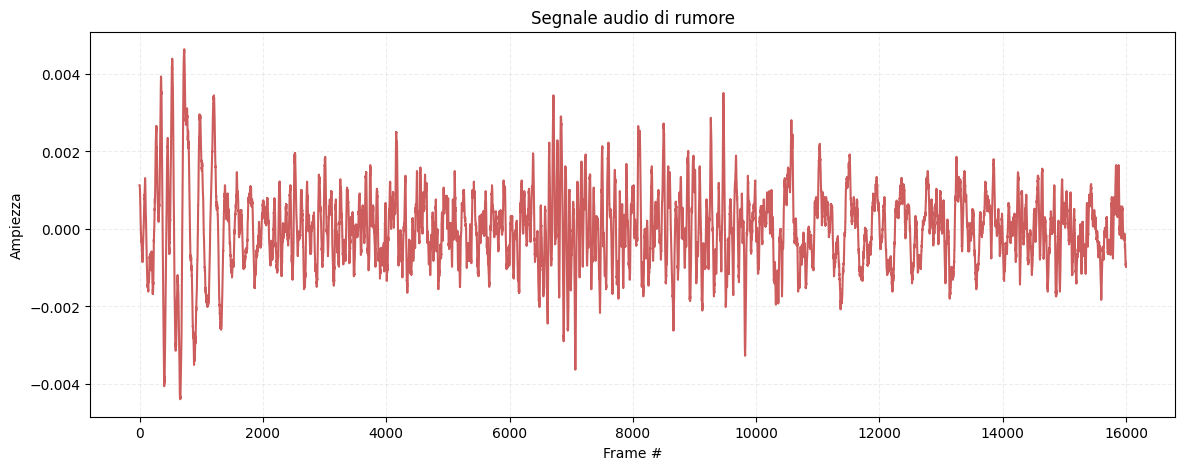

In [7]:
# Plot the waveform
plt.figure(figsize=(14, 5))
plt.plot(new_noise_audios[4], color="indianred")
plt.title('Segnale audio di rumore')
plt.ylabel('Ampiezza')
plt.xlabel('Frame #')
plt.grid(True, color="gainsboro", linestyle="--", alpha=0.5)
plt.show()

In [8]:
mixed_dataset = []

counter = 0

train_ds = train_ds.unbatch()
labels_np = np.array([label.numpy() for _, label in train_ds])

for audio, label in train_ds:    
    audio = np.squeeze(audio, axis=-1)
    # Scegliamo in modo randomico un audio dalla lista ri
    
    noise_sample = random.choice(new_noise_audios)

    mixed_audio = audio + noise_sample # mo00ltiplichiamo per un valore costante molto piccoli cosi da ridurre il volume del rumore e far sentire meglio l'audio del comando
        
    # appendiamo alla lista mixed dataset
    mixed_dataset.append((mixed_audio, label))

# trasformiamo la lista mixed_dataset in un dataset da poter passare ai modelli
# mixed_dataset = tf.data.Dataset.from_tensor_slices(mixed_dataset)

In [9]:
print(mixed_dataset[0])

(array([ 0.00061035,  0.00033569, -0.00042725, ...,  0.00146484,
        0.00067139,  0.00021362], dtype=float32), <tf.Tensor: shape=(), dtype=int32, numpy=27>)


In [10]:
audio_data = [tf.convert_to_tensor(audio, dtype=tf.float32) for audio, label in mixed_dataset]
labels = [label for _, label in mixed_dataset]

In [11]:
mixed_dataset = tf.data.Dataset.from_tensor_slices((audio_data, labels))

In [12]:
counter = 0

for audio, label in mixed_dataset:
    print(audio)
    print(label)
    display(Audio(audio, rate=16000))

    if counter == 2:
        break

    counter += 1



tf.Tensor(
[ 0.00061035  0.00033569 -0.00042725 ...  0.00146484  0.00067139
  0.00021362], shape=(16000,), dtype=float32)
tf.Tensor(27, shape=(), dtype=int32)


tf.Tensor(
[-0.04086304 -0.02334595 -0.0043335  ... -0.06311035 -0.0604248
 -0.05728149], shape=(16000,), dtype=float32)
tf.Tensor(11, shape=(), dtype=int32)


tf.Tensor(
[-0.05749512 -0.05819702 -0.0579834  ...  0.03720093  0.03918457
  0.03955078], shape=(16000,), dtype=float32)
tf.Tensor(12, shape=(), dtype=int32)
